In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
import HDF5

In [2]:
include("../model-41/likelihood.jl")
include("../model-41/utill_model.jl")
include("../utill.jl")

plot_projections (generic function with 1 method)

In [3]:
function hist_2d(smpls, dim_1, dim_2; nbins=40, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

hist_2d (generic function with 1 method)

In [45]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058 

function trunc_norm(m, sgm; alpha=2)
    return truncated(Normal(m, sgm), m - alpha*sgm, m + alpha*sgm)
end

prior_1 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.50 .. 1.0 ,
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    )

prior_2 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.5 .. 1.0 , # should be from 0.3
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
        psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
        cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
        cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
);

prior_3 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.5 .. 1.0 , # should be from 0.3
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [trunc_norm(1, 0.5), trunc_norm(1, 1), trunc_norm(1, 0.5)], # 23, 24, 25, 
        resy = [trunc_norm(1, 0.5), trunc_norm(1, 1), trunc_norm(1, 0.5)], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
        psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
        cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
        cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
);

In [46]:
FPATH = "../../data/sampling_results/Benchmark-12/"

"../../data/sampling_results/Benchmark-12/"

In [47]:
smpl_tmp = bat_read(FPATH*"samples-41-wopx.hdf5").result
samples_1 = varshape(prior_1).(smpl_tmp);

smpl_tmp = bat_read(FPATH*"samples-41-wpx.hdf5").result
samples_2 = varshape(prior_2).(smpl_tmp);

smpl_tmp = bat_read(FPATH*"samples-41-wpx-wre.hdf5").result
samples_3 = varshape(prior_3).(smpl_tmp);

In [48]:
length(samples_1)

891858

In [49]:
length(samples_2)

445999

In [51]:
length(samples_3)

807296

In [52]:
mode(samples_1)[1]

(tr_size = [0.09022016247626924, 0.13278027377370621], tr_size_2 = [0.13087542193714233, 0.15158061149510935], ang_spr = [6.227488514589307, 5.755259786375036], ang_spr_2 = [2.6057915179686617, 2.397589287133589], mixt_pow = 0.666006673110822, waist = [3.1425423563421417], waist_2 = [2.8738232953734717], algmx = [31.741703234746318, 32.22277650028469, 21.291812547178893, 35.2540699308112], algmy = [36.930260443041675, 37.40757355716955, 20.25845816811686, 33.90824607487838], cam4_ped = 27.57169693775633, cam4_light_fluct = 1.365633716171961, cam4_light_amp = 8.846914204881422, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 4.827560766404559, cam4_resy = 4.7854307298949275, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.532172007081927, 11.430580961050259, 2.6946677414758087], s_cam = [0.0, 1.478, 15.026, 23.115])

In [53]:
mean(samples_2)[1]

(tr_size = [0.0878519961539076, 0.12866022233571744], tr_size_2 = [0.12902210242712175, 0.15079362011069766], ang_spr = [6.19024477773182, 5.857650477620992], ang_spr_2 = [2.588849789593126, 2.562888564761092], mixt_pow = 0.6637996669015424, waist = [3.1432584577998495], waist_2 = [2.8452911119799555], algmx = [31.746138368290342, 32.212858589140744, 21.306006253104623, 35.23878081807115], algmy = [36.9366503085647, 37.42832463953376, 20.20877073636263, 33.90756814170225], cam4_ped = 27.241110112069173, cam4_light_fluct = 1.3546372961708204, cam4_light_amp = 8.86361829027101, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 4.7950133563577655, cam4_resy = 4.376420465340611, psx = [26.591733178081864, 21.376506600855908, 115.6945153580543], psy = [30.75605991888799, 23.00978240863821, 126.80768052269605], cam4_psx = 120.45927938902344, cam4_psy = 118.73315756117424, light_amp = [8.540774256501175, 11.414773421628986, 2.6862654997714475], s_cam = [0.0, 1.478, 15.026, 23.115])

In [54]:
mean(samples_3)[1]

(tr_size = [0.08230176446021915, 0.11876077855806214], tr_size_2 = [0.12628660622774754, 0.1443577988369611], ang_spr = [6.21688429579282, 5.886382646443409], ang_spr_2 = [2.6448462820478067, 2.61758300854103], mixt_pow = 0.6678287196629644, waist = [3.1614324163546916], waist_2 = [2.8463248239057446], algmx = [31.746161171131536, 32.2139486930608, 21.308271801273108, 35.23870273823629], algmy = [36.93905891664611, 37.42747476915398, 20.207823530762035, 33.907962914576586], cam4_ped = 27.296430547883826, cam4_light_fluct = 1.354958449655269, cam4_light_amp = 8.862152544904148, resx = [0.7529073905888063, 1.6054292307587186, 0.7186912888880602], resy = [0.6952603302489732, 2.3795065633706423, 0.8111597769627247], cam4_resx = 4.672347839477518, cam4_resy = 4.245207709555047, psx = [26.495866313272668, 21.521784674027757, 115.69255770079164], psy = [30.103938801898295, 23.272873867441106, 126.81765617804656], cam4_psx = 120.46433920760217, cam4_psy = 118.73827775438441, light_amp = [8.553

In [55]:
function plot_contour(ax, hist; kwargs...)
    ax.contour(midpoints(hist.edges[1]), midpoints(hist.edges[2]), hist.weights', 
        levels=range(minimum(hist.weights'), maximum(hist.weights'), length=8)[2:end]; #corner_mask= true,
        kwargs..., antialiased=true) 
end

function plot_contourf(ax, hist; kwargs...)
    ax.contourf(midpoints(hist.edges[1]), midpoints(hist.edges[2]), hist.weights', 
        levels=range(minimum(hist.weights'), maximum(hist.weights'), length=8)[2:end]; #corner_mask= true,
        kwargs..., antialiased=true) 
end

plot_contourf (generic function with 1 method)

In [56]:
hist_1_1 = hist_2d(samples_1, 1,2)
hist_1_2 = hist_2d(samples_1, 3,4)

hist_2_1 = hist_2d(samples_2, 1,2)
hist_2_2 = hist_2d(samples_2, 3,4)

hist_3_1 = hist_2d(samples_3, 1,2)
hist_3_2 = hist_2d(samples_3, 3,4);

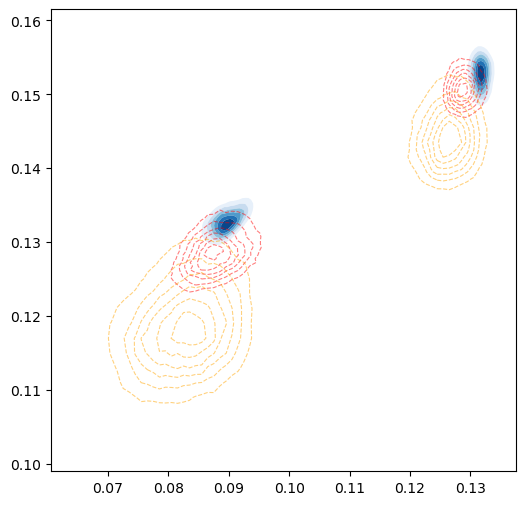

PyObject <matplotlib.contour.QuadContourSet object at 0x7f2bb755f040>

In [57]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plot_contourf(ax, hist_1_1, cmap=:Blues)
plot_contourf(ax, hist_1_2, cmap=:Blues)
plot_contour(ax, hist_2_1, colors=:red, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_2_2, colors=:red, linewidths=0.8, alpha=0.5, linestyles=:dashed)

plot_contour(ax, hist_3_1, colors=:orange, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_3_2, colors=:orange, linewidths=0.8, alpha=0.5, linestyles=:dashed)

In [40]:
function def_datasets(samples_init, samples_ext, indid; nsampls=200)
    samples_init = bat_sample(samples_init, OrderedResampling(nsamples=nsampls)).result
    samples_init = flatview(unshaped.(samples_init.v))
    samples_ext = bat_sample(samples_ext, OrderedResampling(nsamples=nsampls)).result
    samples_ext = flatview(unshaped.(samples_ext.v))
    
    samples_init = samples_init[indid,:] 
    samples_ext = samples_ext[indid,:] 
    
    return samples_init, samples_ext
end

def_datasets (generic function with 1 method)

In [41]:
tmp_1 = def_datasets(samples_1, samples_2, [1,2,3]);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44


In [44]:
tmp_1[2]

3×185 Array{Float64,2}:
 0.082695  0.0884963  0.0895411  …  0.0913205  0.0921276  0.0926366
 0.127381  0.129349   0.126673      0.12627    0.131407   0.133929
 0.126583  0.126814   0.128936      0.132971   0.131834   0.130985

In [18]:
? BAT.OrderedResampling

```
struct OrderedResampling <: AbstractSamplingAlgorithm
```

Efficiently resamples from a given series of samples, keeping the order of samples.

Can be used to efficiently convert weighted samples into samples with unity weights.

Constructors:

  * `OrderedResampling(; fields...)`

Fields:

  * `nsamples::Int64`

    Default: 10 ^ 5


In [ ]:
dims = [1,2,3,4,5,6,]
names = dims
levels = [0.0001, 0.65, 0.9, 0.95,  1,]
levels = [0.01, 0.95, 1,]
figsize = (12,12)
n_bins = 20

corner_plots(samples_2, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = 7:14
names = dims
levels = [0.0001, 0.65, 0.9, 0.95,  1,]
levels = [0.01, 0.95, 1,]
figsize = (12,12)
n_bins = 20

corner_plots(samples_2, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = 7:22
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.01,  0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples_4, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = 20:27
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples_4.v))'))), cmap="Blues")

In [ ]:
dt_reg = flatview(unshaped.(samples_4.v)) ./ std(flatview(unshaped.(samples_4.v)), dims=2)
dt_reg = dt_reg .- mean(dt_reg, dims=2)
dt_reg = cov(dt_reg')
max = maximum(abs.(dt_reg))

plt.imshow(dt_reg, cmap="seismic", vmin=-max, vmax=max)

In [ ]:
if true
    
    conv_mat = load("../../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
    event_number = 2

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
    
    images = load("../../data/experiment/dataset_2/m2/images.jld2")

    global event_nt = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
end

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples_4)[1], mean(samples_2)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [ ]:
# include("../model-35-rot/likelihood.jl")
# include("../model-35-rot/utill_model.jl")
# include("../utill.jl")

include("../model-35/likelihood.jl")
include("../model-35/utill_model.jl")
include("../utill.jl")

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["samples_1", "samples_2"]
params_array = [mode(samples_1)[1], mode(samples_2)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [ ]:
params_array = [mode(samples_2)[1],]
colors_array = ["gray",]
labels_array = ["Truth", ]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [ ]:
plot_projections(conv_matrices, event_nt, event_nt, params_array[1], isnontr = true)